In [44]:
from tools import analysistools as atools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
from scipy.stats import sem
from mpl_toolkits.mplot3d import Axes3D
#import hurst

In [45]:
xyzapath = '/Users/joel/Projects/optidb/upgrade/51-4'

In [46]:
xyzas = [os.path.join(xyzapath,f) for f in filter(lambda x: '.xyza' in x, os.listdir(xyzapath))]

In [47]:
nxyzas = filter(lambda c: '-1' in c, xyzas)
bxyzas = filter(lambda c: '-1' not in c, xyzas)

In [48]:
# contacts = [atools.measureLigandContact(f) for f in random.sample(xyzas,10)]

In [ ]:
nonBudContacts = [atools.measureLigandContact(f) for f in nxyzas]
budContacts = [atools.measureLigandContact(f) for f in bxyzas]

In [ ]:
mbcontact = {}
mbcontactlist = []
mberr = []

nbcontact = {}
nbcontactlist = []
nberr = []

if len(budContacts) > 0:
    for x in budContacts[0][0]:
        mbcontact[x[0]] = []
        mbcontactlist.append([x[0],[]])
    for f in budContacts:
        for g in f[0]:
            mbcontact[g[0]].append(g[1])
    for v in mbcontactlist:
        v[1] = np.mean(mbcontact[v[0]])
        mberr.append([v[0],np.std(mbcontact[v[0]])])
    
if len(nonBudContacts) > 0:
    for x in nonBudContacts[0][0]:
        nbcontact[x[0]] = []
        nbcontactlist.append([x[0],[]])
    for f in nonBudContacts:
        for g in f[0]:
            nbcontact[g[0]].append(g[1])
    for v in nbcontactlist:
        v[1] = np.mean(nbcontact[v[0]])
        nberr.append([v[0],np.std(nbcontact[v[0]])])

mbcontact = {}
nbcontact = {}

In [ ]:
plt.errorbar([p[0] for p in mbcontactlist],[p[1] for p in mbcontactlist],yerr=[p[1] for p in mberr],alpha=0.4)
plt.errorbar([p[0] for p in nbcontactlist],[p[1] for p in nbcontactlist],yerr=[p[1] for p in nberr],alpha=0.4)
# for contact in nonBudContacts:
#     plt.plot([i[0] for i in contact[0]],[i[1] for i in contact[0]],color='blue')

In [ ]:
njitters = [atools.jitterLigandContact(c[0],3,'full') for c in nonBudContacts]
bjitters = [atools.jitterLigandContact(c[0],3,'full') for c in budContacts]

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(1,16):
    ax = plt.subplot(4, 5, i)
    if i in bjitters:
        ax.plot(bjitters[i][1])


In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(1,16):
    ax = plt.subplot(4, 5, i)
    if i in njitters:
        ax.plot(njitters[i][1])

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(1,16):
    ax = plt.subplot(4, 5, i)
    if i in bjitters:
        corr = np.correlate(bjitters[i][1],bjitters[i][1],mode='full')
        ax.plot(corr)

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(1,16):
    ax = plt.subplot(4, 5, i)
    if i in njitters:
        corr = np.correlate(njitters[i][1],njitters[i][1],mode='full')
        ax.plot(corr)

In [ ]:
nmeans = []
nsds = []
for c in njitters:
    sns.distplot(c[1][:],kde=False,norm_hist=True)
    nmeans.append(np.mean(c[1]))
    nsds.append(np.std(c[1]))

In [ ]:
bmeans = []
bsds = []
for c in bjitters:
    sns.distplot(c[1][:],kde=False,norm_hist=True)
    bmeans.append(np.mean(c[1]))
    bsds.append(np.std(c[1]))

In [ ]:
print(np.mean(bmeans),np.mean(nmeans))

In [ ]:
print(np.mean(bsds),np.mean(nsds))

In [ ]:
def readXYZA(filepath,headerSize=8):
    data = {}
    with open(filepath, "r") as f:
        lines = f.readlines()
        ts = 0
        steps = []
        hPos = 0
        currentStep = {}
        for i in range(len(lines)):
            if str('ITEM: TIMESTEP') in lines[i]:
                if 't' in currentStep:
                    steps.append(currentStep)   
                hPos = i
                ts = int(lines[i+1])
                currentStep = {'t':ts,'data':[]}
            elif str('ITEM: NUMBER OF ATOMS') in lines[i]:
                data['natoms'] = int(lines[i+1])  
            elif str('ITEM: BOX BOUNDS') in lines[i]:
                currentStep['xsize'] = [float(b) for b in lines[i+1].split(' ')]
                currentStep['ysize'] = [float(b) for b in lines[i+2].split(' ')]
                currentStep['zsize'] = [float(b) for b in lines[i+3].split(' ')]
            elif str('ITEM: ATOMS') in lines[i]:
                data['columns'] = lines[i].replace('\n','').split(' ')[2:]
            if(i-hPos>headerSize):
                atomStep = {}
                atomData = lines[i].replace('\n','').split(' ')
                for j,c in enumerate(data['columns']):
                    try:
                        atomStep[c] = float(atomData[j]) if ('.' in atomData[j] or 'e' in atomData[j]) else int(atomData[j])
                    except:
                        continue
                currentStep['data'].append(atomStep)
        data['steps'] = steps
    return data
            

In [ ]:
def getRotationData(simData):
    coreId = -1
    refId = -1
    for i,a in enumerate(simData['steps'][0]['data']):
        if a['type'] == 2:
            coreId = i
        if a['type'] == 3:
            refId = i

    r = []
    rotation = []
    
    for i,s in enumerate(simData['steps']):
        core = s['data'][coreId]
        ref = s['data'][refId]
        vCore = [core['x'],core['y'],core['z']]
        vRef = [ref['x'],ref['y'],ref['z']]
        r.append(np.subtract(vRef,vCore))
        if i>0:
            rotation.append(r[-1])
            
    return rotation

In [ ]:
def getPolarRotationData(simData):
    rotation = getRotationData(simData)
    return [atools.crt2SphPol(r) for r in rotation]

In [ ]:
def getAngularDisplacement(simData):
    rotation = getPolarRotationData(simData)
    return [np.subtract(r,rotation[0]) for r in rotation]

In [ ]:
def getDisplacement(simData):
    rotation = getRotationData(simData)
    return [np.subtract(r,rotation[0]) for r in rotation]

In [ ]:
def plotRotationTrajectory(data):
    colors = []
    colStep = 1.0/float(len(data))
    for i in range(len(data)):
        colors.append((colStep*i,0.0,1.0-colStep*i,1.0))
        
    startPoint = 0
    X, Y, Z = zip(*data[startPoint:])
    fig = plt.figure(figsize=(13, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(X,Y,Z,alpha=0.4)
    ax.scatter(X, Y, Z,c=colors[startPoint:])
    return fig

In [ ]:
def plotRotationTrajectoryOnSphere(data):
    colors = []
    colStep = 1.0/float(len(data))
    for i in range(len(data)):
        colors.append((colStep*i,0.0,1.0-colStep*i,1.0))
        
    startPoint = 0
    X, Y, Z = zip(*data[startPoint:])
    fig = plt.figure(figsize=(13, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(X,Y,Z,alpha=0.4)
    ax.set_xlim([-4.0,4.0])
    ax.set_ylim([-4.0,4.0])
    ax.set_zlim([-4.0,4.0])
    u, v = np.mgrid[0:2*np.pi:200j, 0:np.pi:200j]
    sx = 4.0*np.cos(u)*np.sin(v)
    sy = 4.0*np.sin(u)*np.sin(v)
    sz = 4.0*np.cos(v)
    ax.plot_wireframe(sx, sy, sz, color="r",alpha=0.05)
    ax.scatter(X, Y, Z,c=colors[startPoint:])
    return fig

In [ ]:
d = readXYZA(bxyzas[1])

In [ ]:

for i in range(10 if len(bxyzas) > 10 else len(bxyzas)):
    r = getRotationData(readXYZA(bxyzas[i]))
    rc = np.corrcoef([p[0] for p in r])
    tc = np.corrcoef([p[1] for p in r])
    pc = np.corrcoef([p[2] for p in r])
    print rc,tc,pc
    
        

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)

rows = 3

for i in range(rows):
    if i in bxyzas:
        r = getRotationData(readXYZA(bxyzas[i]))
        ax = plt.subplot(3, rows, i*3+1)
        corr = np.correlate([p[0] for p in r], [p[0] for p in r], mode='same')
        ax.plot(corr)
        ax = plt.subplot(3, rows, i*3+2)
        corr = np.correlate([p[1] for p in r], [p[1] for p in r], mode='full')
        ax.plot(corr)
        ax = plt.subplot(3, rows, i*3+3)
        corr = np.correlate([p[2] for p in r], [p[2] for p in r], mode='full')
        ax.plot(corr)
#     plotRotationTrajectory(r)
plt.show()

In [ ]:
rotation = getAngularDisplacement(readXYZA(random.sample(bxyzas,1)[-1]))
#plt.plot([r[0] for r in rotation],label="r")
plt.plot([r[1] for r in rotation],label="theta")
plt.plot([r[2] for r in rotation],label="phi")
plt.legend()
plt.show()


In [ ]:
H, c, data = hurst.compute_Hc([r[1] for r in rotation])
print H
H, c, data = hurst.compute_Hc([r[2] for r in rotation])
print H

In [ ]:
rotation = getAngularDisplacement(readXYZA(random.sample(bxyzas,1)[-1]))
#plt.plot([r[0] for r in rotation],label="r")
plt.plot([r[1] for r in rotation],label="theta")
plt.plot([r[2] for r in rotation],label="phi")
plt.legend()
plt.show()

In [ ]:
H, c, data = hurst.compute_Hc([r[1] for r in rotation])
print H
H, c, data = hurst.compute_Hc([r[2] for r in rotation])
print H

In [ ]:
plotRotationTrajectoryOnSphere(getRotationData(readXYZA(bxyzas[-2])))
plt.show()

In [43]:
bData = getRotationData(readXYZA(bxyzas[-1]))

In [66]:
budHurst = []
for b in bxyzas:
    rotation = getAngularDisplacement(readXYZA(b))
    H1, c1, data1 = hurst.compute_Hc([r[1] for r in rotation])
    H2, c2, data2 = hurst.compute_Hc([r[2] for r in rotation])
    budHurst.append([H1,H2])

In [67]:
nonHurst = []
for n in nxyzas:
    rotation = getAngularDisplacement(readXYZA(n))
    H1, c1, data1 = hurst.compute_Hc([r[1] for r in rotation])
    H2, c2, data2 = hurst.compute_Hc([r[2] for r in rotation])
    nonHurst.append([H1,H2])

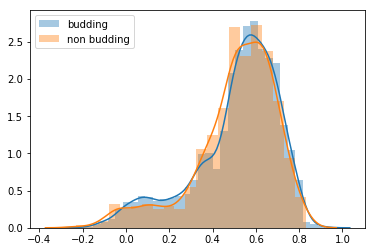

In [68]:
sns.distplot([b[1] for b in budHurst],label="budding")
sns.distplot([b[1] for b in nonHurst],label="non budding")
plt.legend()
plt.show()

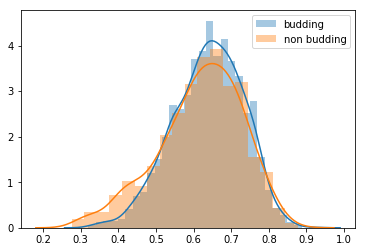

In [69]:
sns.distplot([b[0] for b in budHurst],label="budding")
sns.distplot([b[0] for b in nonHurst],label="non budding")
plt.legend()
plt.show()

In [72]:
from scipy import stats
print stats.ttest_ind([b[0] for b in budHurst],[b[0] for b in nonHurst])

Ttest_indResult(statistic=4.530998263014185, pvalue=6.109721895608975e-06)


In [73]:
print stats.ttest_ind([b[1] for b in budHurst],[b[1] for b in nonHurst])

Ttest_indResult(statistic=0.5903787833877695, pvalue=0.5549830841588728)


In [87]:
zooparticles = ["/Users/joelforster/Projects/optihedron/out/sim_gs_264_"+str(i)+"_out.xyza" for i in range(4)]

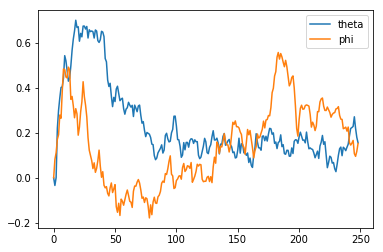

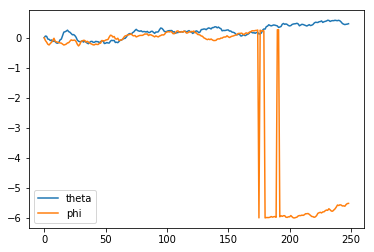

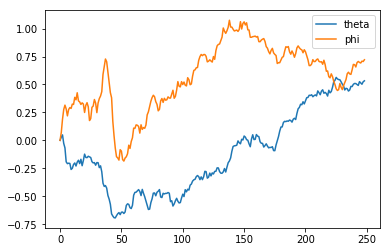

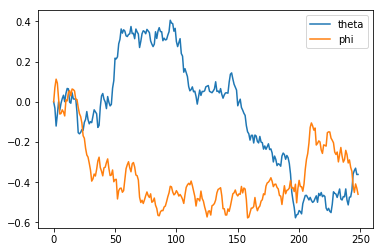

In [89]:
zooHurst = []
for i in zooparticles:
    rotation = getAngularDisplacement(readXYZA(i))
    H1, c1, data1 = hurst.compute_Hc([r[1] for r in rotation])
    H2, c2, data2 = hurst.compute_Hc([r[2] for r in rotation])
    zooHurst.append([H1,H2])
    #plt.plot([r[0] for r in rotation],label="r")
    plt.plot([r[1] for r in rotation],label="theta")
    plt.plot([r[2] for r in rotation],label="phi")
    plt.legend()
    plt.show()

In [90]:
print zooHurst

[[0.5238625977744695, 0.4673762310701783], [0.4864782949019711, 0.16464419169039737], [0.6499050708792441, 0.566026937290961], [0.6326896557098346, 0.505986462401568]]
